In [1]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
import os

d:\GITHUB\Projects\ChatBot_In_LangGraph\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()

True

In [3]:
class ParentState(TypedDict):

    question: str
    answer_eng: str
    answer_hin: str


In [4]:
parent_llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-lite-001",
    temperature=0.1,
    max_retries=0,          # 🔥 critical
    max_output_tokens=256
)
subgraph_llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-lite-001",
    temperature=0.1,
    max_retries=0,          # 🔥 critical
    max_output_tokens=256
)

In [5]:
def translate_text(state: ParentState):

    prompt = f"""
Translate the following text to Hindi.
Keep it natural and clear. Do not add extra content.

Text:
{state["answer_eng"]}
""".strip()
    
    translated_text = subgraph_llm.invoke(prompt).content

    return {'answer_hin': translated_text}

In [6]:

subgraph_builder = StateGraph(ParentState)

subgraph_builder.add_node('translate_text', translate_text)

subgraph_builder.add_edge(START, 'translate_text')
subgraph_builder.add_edge('translate_text', END)

subgraph = subgraph_builder.compile()

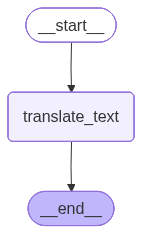

In [7]:
subgraph

In [8]:
def generate_answer(state: ParentState):

    answer = parent_llm.invoke(f"You are a helpful assistant. Answer clearly.\n\nQuestion: {state['question']}").content
    return {'answer_eng': answer}

In [9]:
parent_builder = StateGraph(ParentState)

parent_builder.add_node("answer", generate_answer)
parent_builder.add_node("translate", subgraph)

parent_builder.add_edge(START, 'answer')
parent_builder.add_edge('answer', 'translate')
parent_builder.add_edge('translate', END)

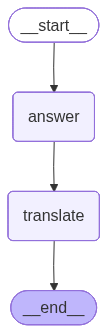

In [10]:
graph = parent_builder.compile()

graph

In [ ]:
graph.invoke({'question': 'What is quantum COMPUTING?"'})